In [1]:
# Standard Library Imports
import re
import warnings
import logging


# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from matplotlib.font_manager import FontProperties

# Text Processing
import hazm
from hazm import *
from urlextract import URLExtract
import emoji
from bidi.algorithm import get_display
from arabic_reshaper import reshape
from tqdm import tqdm

# Machine Learning - Model Selection and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Machine Learning - Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier, SGDClassifier, Perceptron

# Suppressing Warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("../../../Data/Farsi/1. Main/farsi_sms.csv", encoding='UTF-8')
df

,Text,Class
0,باید نهایتا ساعت ۶:۵۰ دقیقه از دم پل هوایی راه...,ham
1,قابل نداره جابجایی دوربین و تنظیم دستگاه دزدگی...,ham
2,سلام آقا مهدی من امشب هم نمیتونم بیام ، کلاس د...,ham
3,۳۰۰ هزار تومن تخفیف اولین استفاده از سرویس «اس...,spam
4,آفرVIPدبی6900 استانبول4800 ⭕تفلیس4800 ✅آنتالیا...,spam
...,...,...
1093,وارد بازارکار شو دوره کارآموزی آنلاین ورایگان ...,spam
1094,"""2 میلیون تخفیف کاشت مو،ابرو"" 🔷با رعایت پروتکل...",spam
1095,۳ برابر شانس بیشتر با خرید شارژ 💥 فقط امروز دو...,spam
1096,ایرانسلی عزیز 💛، بدون پرداخت هزینه آنی مکالمه ...,spam


In [ ]:
df.shape

(1098, 2)

In [ ]:
# Check for duplicates and remove them if found
if df.duplicated().sum() > 0:
    print("Found duplicate rows. Removing them...")
    df = df.drop_duplicates()

In [ ]:
# Check for missing values
missing_values = df.isna().sum()
if missing_values.any():
    print("Found missing values. Removing them...")
    df = df.dropna()

Found missing values. Removing them...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1096 entries, 0 to 1097
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    1096 non-null   object
 1   Class   1096 non-null   object
dtypes: object(2)
memory usage: 25.7+ KB


In [ ]:
# adding some usfule columns to the dataset

# number of words in a message
df['NO_words'] = df['Text'].apply(lambda x:len(hazm.word_tokenize(x)))

# number of characters in a message
df['NO_characters'] = df['Text'].apply(len)

# number of sentence in message
df['NO_sentences'] = df['Text'].apply(lambda x:len(hazm.sent_tokenize(x)))

# number of emojis in sentece
df['NO_emojis'] = df['Text'].apply(lambda x: emoji.emoji_count(x))

In [ ]:
df.head()

,Text,Class,NO_words,NO_characters,NO_sentences,NO_emojis
0,باید نهایتا ساعت ۶:۵۰ دقیقه از دم پل هوایی راه...,ham,12,60,1,1
1,قابل نداره جابجایی دوربین و تنظیم دستگاه دزدگی...,ham,11,58,1,0
2,سلام آقا مهدی من امشب هم نمیتونم بیام ، کلاس د...,ham,20,89,3,1
3,۳۰۰ هزار تومن تخفیف اولین استفاده از سرویس «اس...,spam,55,225,3,0
4,آفرVIPدبی6900 استانبول4800 ⭕تفلیس4800 ✅آنتالیا...,spam,11,70,1,2


In [ ]:
# Descriptive statistics of text features
df.describe()

,NO_words,NO_characters,NO_sentences,NO_emojis
count,1096.000000,1096.000000,1096.000000,1096.000000
mean,30.826642,131.635949,1.565693,0.632299
std,22.730284,97.115643,0.854358,1.634339
min,1.000000,3.000000,1.000000,0.000000
25%,13.000000,65.000000,1.000000,0.000000
50%,22.000000,97.500000,1.000000,0.000000
75%,46.000000,187.250000,2.000000,0.000000
max,114.000000,537.000000,5.000000,18.000000


In [ ]:
# Descriptive statistics of text features for HAM messages
df[df['Class'] == "ham"][['NO_characters', 'NO_words', 'NO_sentences', 'NO_emojis']].describe()

,NO_characters,NO_words,NO_sentences,NO_emojis
count,459.000000,459.00000,459.000000,459.000000
mean,101.283224,22.72549,1.403050,0.102397
std,97.090436,21.89701,0.793582,0.901463
min,3.000000,1.00000,1.000000,0.000000
25%,39.500000,9.00000,1.000000,0.000000
50%,68.000000,15.00000,1.000000,0.000000
75%,124.500000,28.00000,2.000000,0.000000
max,537.000000,114.00000,5.000000,18.000000


In [ ]:
# Descriptive statistics of text features for SPAM messages
df[df['Class'] == "spam"][['NO_characters', 'NO_words', 'NO_sentences', 'NO_emojis']].describe()

,NO_characters,NO_words,NO_sentences,NO_emojis
count,637.000000,637.000000,637.000000,637.000000
mean,153.507064,36.664050,1.682889,1.014129
std,91.136234,21.511958,0.877697,1.914391
min,35.000000,7.000000,1.000000,0.000000
25%,69.000000,17.000000,1.000000,0.000000
50%,132.000000,33.000000,1.000000,0.000000
75%,209.000000,52.000000,2.000000,1.000000
max,507.000000,111.000000,5.000000,15.000000


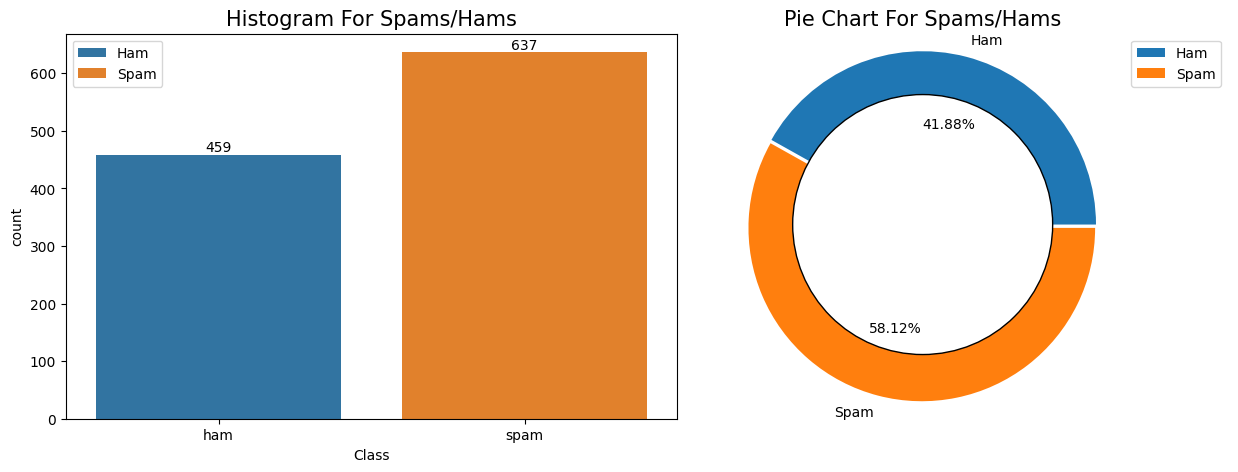

In [ ]:
# Calculate number of each class (ham or spam)
spam_count = df['Class'].value_counts()['spam']
ham_count = df['Class'].value_counts()['ham']

# Plotting
labels = ['Ham', 'Spam']
plt.figure(figsize=(15, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='Class', hue='Class', alpha=1)
plt.legend(labels)
plt.title('Histogram For Spams/Hams', size=15)

# Annotate histogram with exact counts
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                       ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Pie Chart
plt.subplot(1, 2, 2)
sizes = [ham_count, spam_count]
explode = [0, 0.02]
plt.pie(sizes, labels=labels, explode=explode, autopct='%1.2f%%')
plt.axis('equal')
plt.legend(labels)
circle = plt.Circle(xy=(0, 0), radius=0.75, facecolor='white', edgecolor='black')
plt.gca().add_artist(circle)
plt.title('Pie Chart For Spams/Hams', size=15)

# Adjust layout to bring subplots closer together
plt.subplots_adjust(wspace= -0.1)  # Reduce the value to bring plots closer

plt.savefig('../../../Data/Farsi/1. Main/F_Spam_vs_Ham_distribution.png', format='png', dpi=1000)

plt.show()


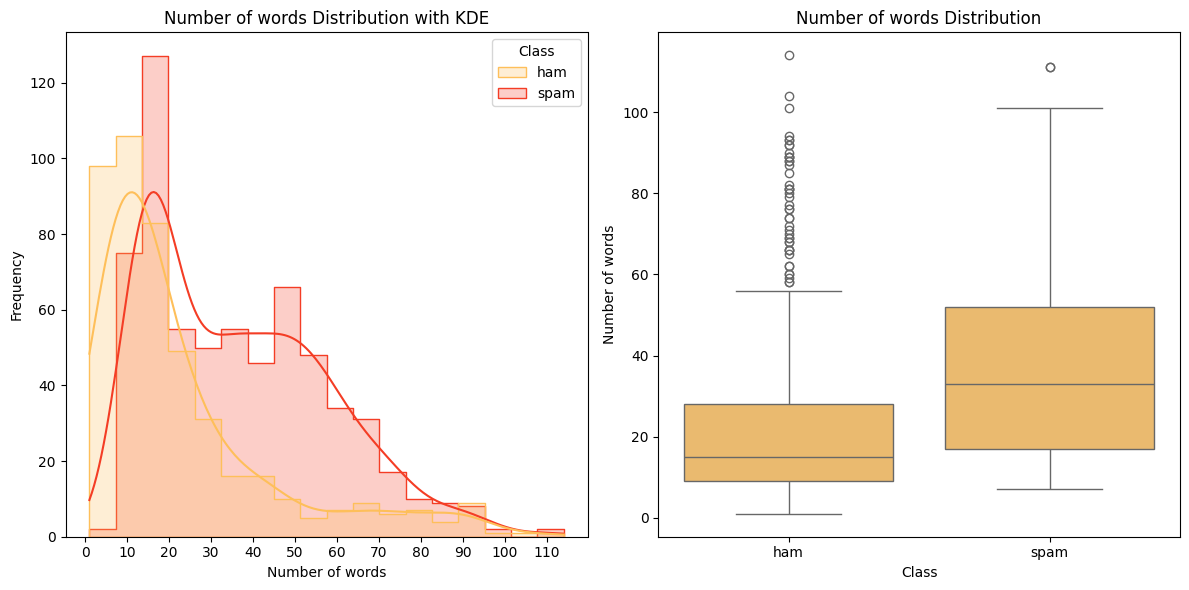

In [ ]:
plt.figure(figsize=(12, 6))

# Define the red palette
red_palette = sns.color_palette("YlOrRd", 2)

# First subplot
plt.subplot(1, 2, 1)
sns.set_palette(red_palette)
sns.histplot(data=df, x='NO_words', hue='Class', kde=True, element='step')
plt.title('Number of words Distribution with KDE')
plt.xticks(range(0, df['NO_words'].max() + 1, 10))  # Adjust the step size as needed
plt.xlabel('Number of words')
plt.ylabel('Frequency')

# Second subplot
plt.subplot(1, 2, 2)
sns.set_palette(red_palette)
sns.boxplot(x='Class', y='NO_words', data=df)
plt.title('Number of words Distribution')
plt.xlabel('Class')
plt.ylabel('Number of words')

# Adjust layout
plt.tight_layout()

plt.savefig('../../../Data/Farsi/1. Main/F_Number of words.png', format='png', dpi=1000)

# Show the plots
plt.show()

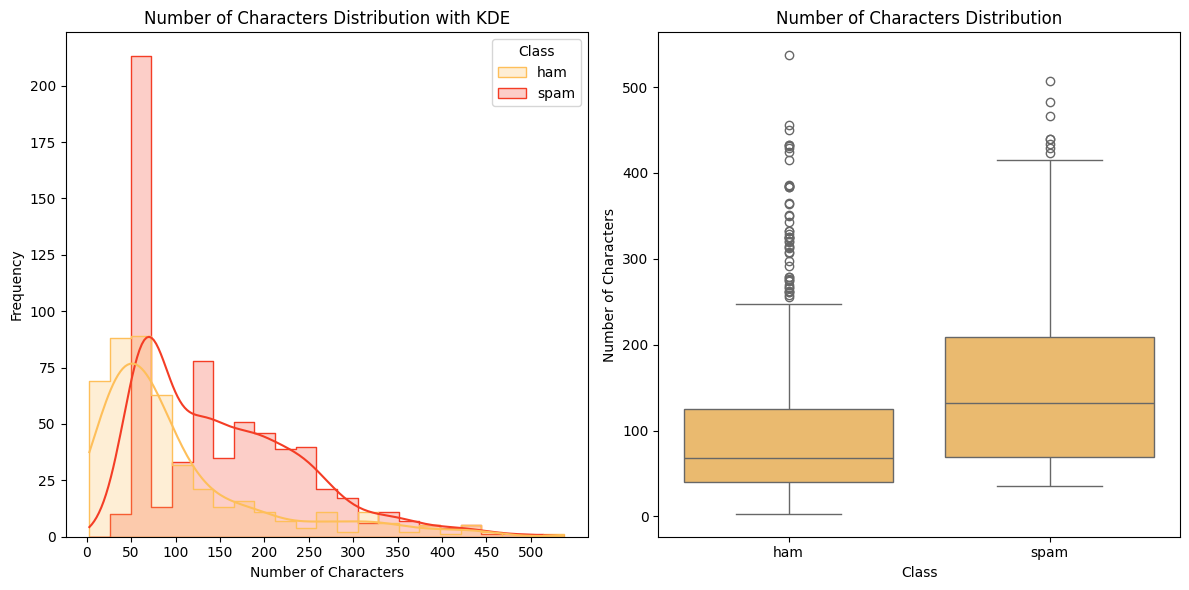

In [ ]:
plt.figure(figsize=(12, 6))

# Define the red palette
red_palette = sns.color_palette("YlOrRd", 2)

# First subplot
plt.subplot(1, 2, 1)
sns.set_palette(red_palette)
sns.histplot(data=df, x='NO_characters', hue='Class', kde=True, element='step')
plt.title('Number of Characters Distribution with KDE')
plt.xticks(range(0, df['NO_characters'].max() + 1, 50))  # Adjust the step size as needed
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

# Second subplot
plt.subplot(1, 2, 2)
sns.set_palette(red_palette)
sns.boxplot(x='Class', y='NO_characters', data=df)
plt.title('Number of Characters Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Characters')

# Adjust layout
plt.tight_layout()

plt.savefig('../../../Data/Farsi/1. Main/F_Number of Characters.png', format='png', dpi=1000)

# Show the plots
plt.show()

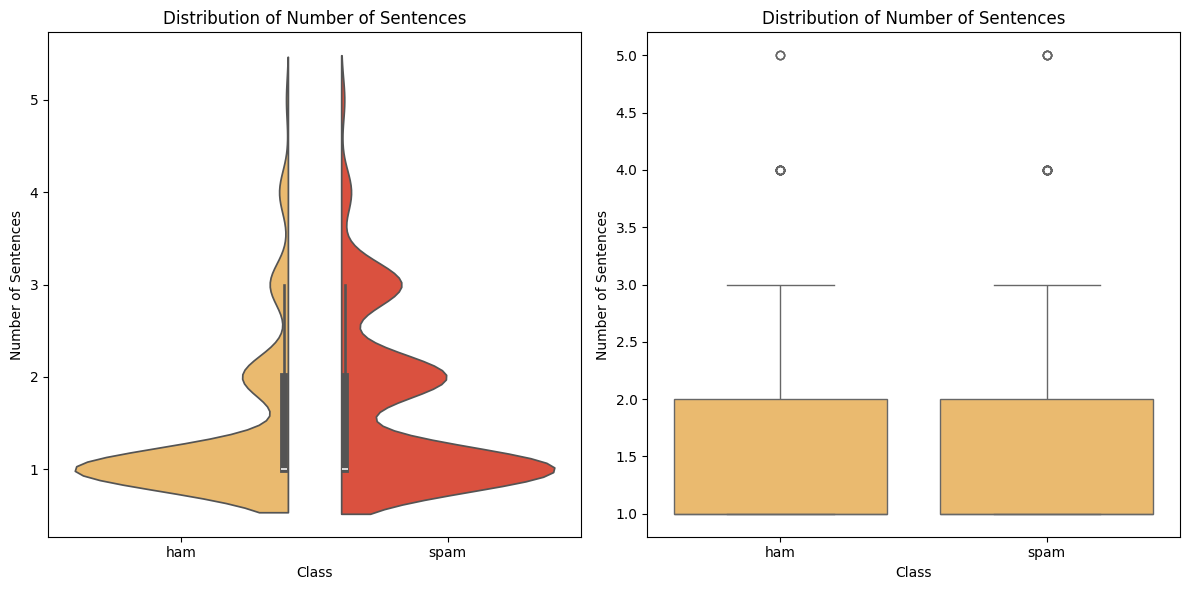

In [ ]:

plt.figure(figsize=(12, 6))

# Define the red palette
red_palette = sns.color_palette("YlOrRd", 2)

# First subplot - Violin Plot
plt.subplot(1, 2, 1)
sns.set_palette(red_palette)
sns.violinplot(data=df, x='Class', y='NO_sentences', hue='Class', split=True)
plt.title('Distribution of Number of Sentences')
plt.xlabel('Class')
plt.ylabel('Number of Sentences')

# Second subplot - Box Plot
plt.subplot(1, 2, 2)
sns.set_palette(red_palette)
sns.boxplot(x='Class', y='NO_sentences', data=df)
plt.title('Distribution of Number of Sentences')
plt.xlabel('Class')
plt.ylabel('Number of Sentences')

# Adjust layout
plt.tight_layout()

plt.savefig('../../../Data/Farsi/1. Main/F_Number of Sentences.png', format='png', dpi=1000)

# Show the plots
plt.show()

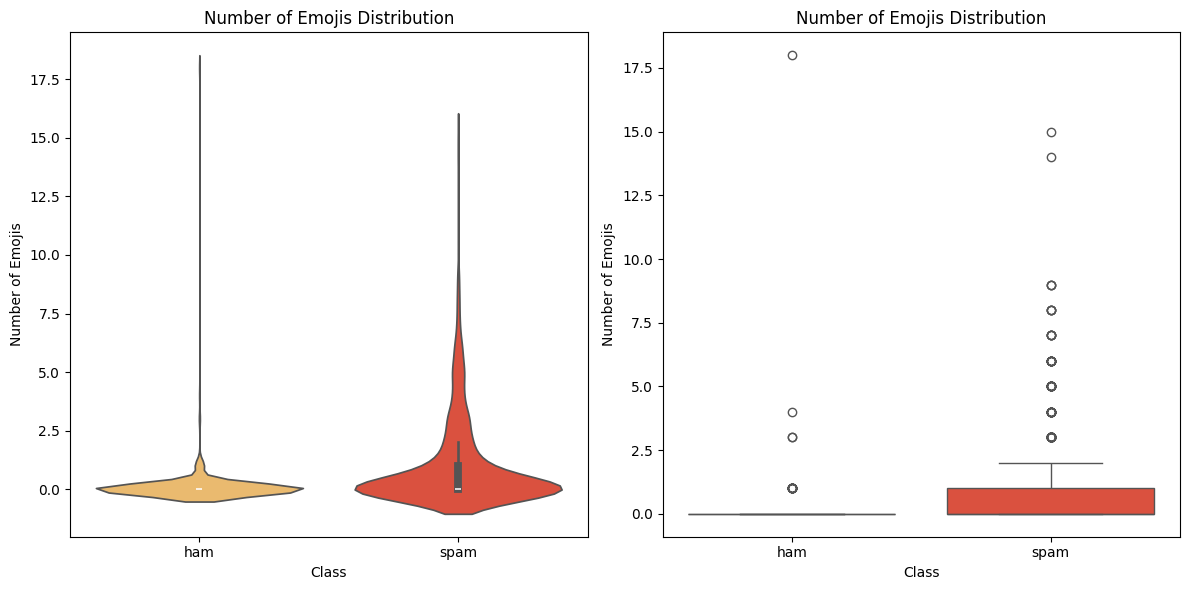

In [ ]:
plt.figure(figsize=(12, 6))

# Subplot for emoji distribution using violin plot
plt.subplot(1, 2, 1)
sns.violinplot(x='Class', y='NO_emojis', data=df, palette=red_palette)
plt.title('Number of Emojis Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Emojis')

# Subplot for emoji distribution by class using box plot
plt.subplot(1, 2, 2)
sns.boxplot(x='Class', y='NO_emojis', data=df, palette=red_palette)
plt.title('Number of Emojis Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Emojis')

plt.tight_layout()

plt.savefig('../../../Data/Farsi/1. Main/F_Number of Emojis.png', format='png', dpi=1000)

plt.show()



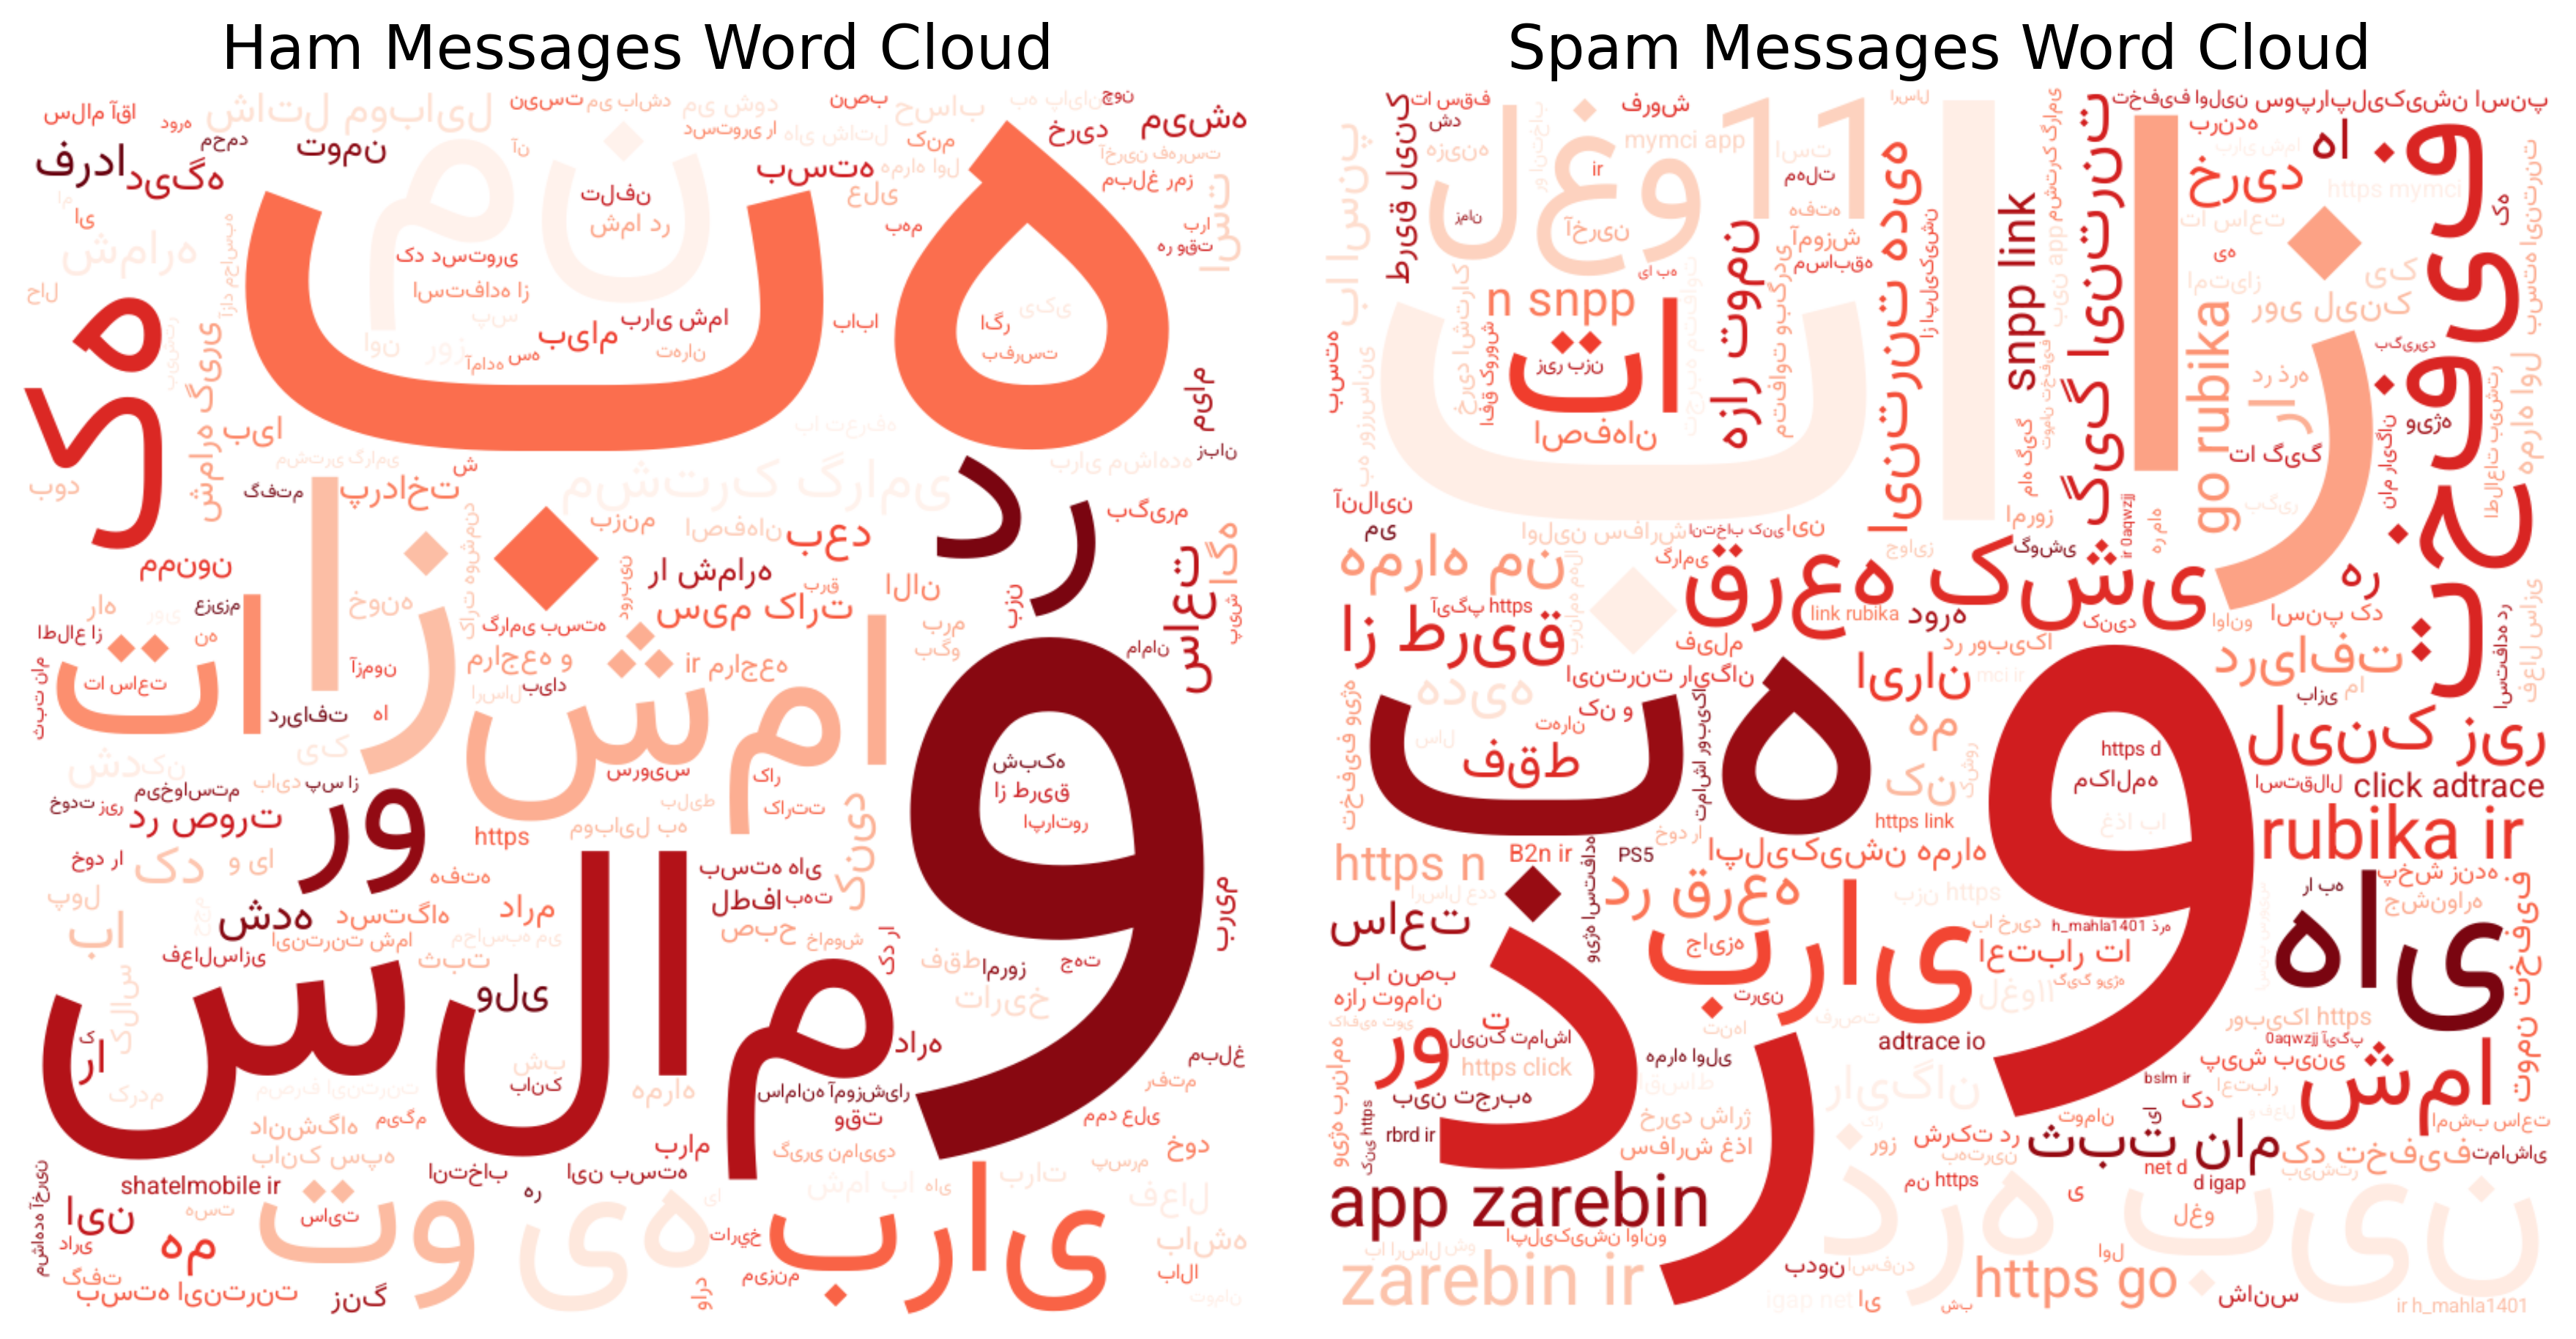

In [ ]:
red_palette_c = sns.color_palette("Reds_r", as_cmap=True)

ham_text = " ".join(df[df['Class'] == "ham"]['Text'].astype(str))
spam_text = " ".join(df[df['Class'] == "spam"]['Text'].astype(str))

font_path ="../../../Data/Farsi/Font/Vazirmatn-VariableFont_wght.ttf"
ham_wordcloud = WordCloud(width=800, height=800, background_color='white', colormap=red_palette_c, font_path=font_path).generate(ham_text)
spam_wordcloud = WordCloud(width=800, height=800, background_color='white', colormap=red_palette_c, font_path=font_path).generate(spam_text)

ham_image = ham_wordcloud.to_array()
spam_image = spam_wordcloud.to_array()

plt.figure(figsize=(12, 6), dpi=300)

plt.subplot(1, 2, 1)
plt.imshow(ham_image, interpolation='bilinear')
plt.title('Ham Messages Word Cloud', fontsize=20)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(spam_image, interpolation='bilinear')
plt.title('Spam Messages Word Cloud', fontsize=20)
plt.axis('off')

plt.tight_layout()

plt.savefig('../../../Data/Farsi/1. Main/Word Cloud.png', format='png', dpi=1000)

plt.show()


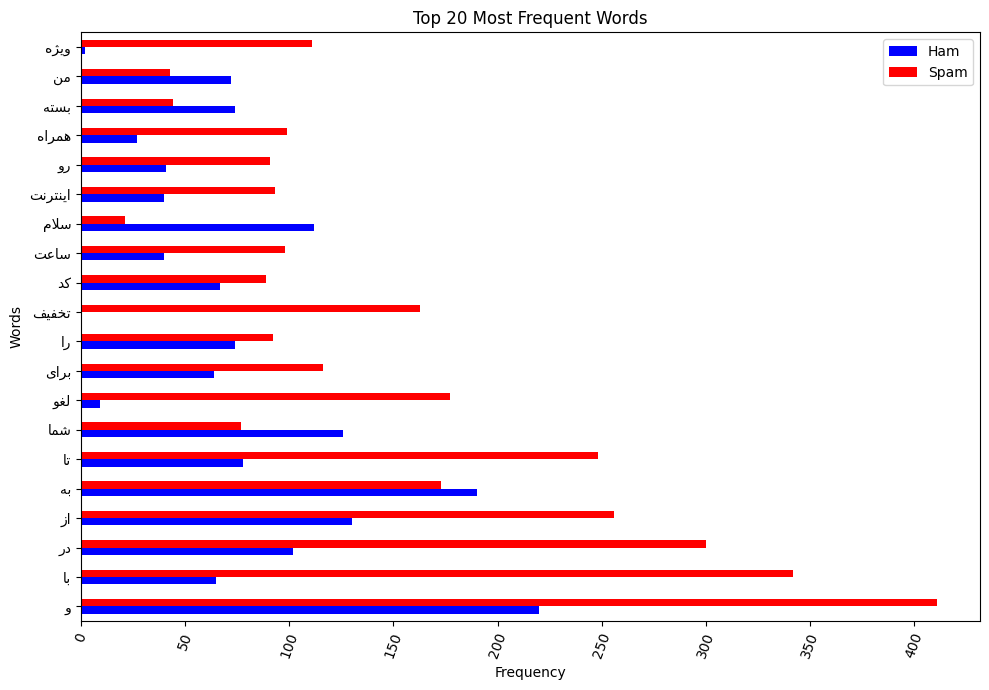

In [ ]:
# Function to clean and tokenize the text
def clean_and_tokenize(text):
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)
    unwanted_patterns = r'[\/:?\.\،\؛!«»؟]|^\d+$|^(https?|ir)$'
    tokens = [token for token in tokens if not re.match(unwanted_patterns, token)]
    return tokens

# Prepare and clean text
ham_text = " ".join(df[df['Class'] == "ham"]['Text'].astype(str))
spam_text = " ".join(df[df['Class'] == "spam"]['Text'].astype(str))
ham_words = clean_and_tokenize(ham_text)
spam_words = clean_and_tokenize(spam_text)

# Calculate term frequency and combine into a single DataFrame
ham_word_counts = pd.Series(ham_words).value_counts()
spam_word_counts = pd.Series(spam_words).value_counts()
combined_word_counts = pd.DataFrame({'Ham': ham_word_counts, 'Spam': spam_word_counts}).fillna(0)

# Calculate the total frequency for sorting
combined_word_counts['Total'] = combined_word_counts.sum(axis=1)

# Sort the DataFrame by total frequency
combined_word_counts = combined_word_counts.sort_values(by='Total', ascending=False)

# Get the top 20 most frequent words
top_words = combined_word_counts.head(20)

# Drop the 'Total' column after sorting
top_words = top_words.drop(columns='Total')

# Reshape and display Farsi text
reshaped_labels = [get_display(reshape(label)) for label in top_words.index]

# Plot term frequency bar chart for the top 20 most frequent words
fig, ax = plt.subplots(figsize=(10, 7))

top_words.plot(kind='barh', ax=ax, color=['blue', 'red'])
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.xticks(rotation=70, ha='center')

# Apply reshaped Farsi labels to the y-axis ticks
ax.set_yticklabels(reshaped_labels)

plt.tight_layout()

plt.savefig('../../../Data/Farsi/1. Main/Top 20 Most Frequent Words.png', format='png', dpi=1000)

plt.show()



as you can see the most freqyency words are the mostly stopwords

# Preprocecing


here I have difined 8 functions, each one for a task.

In [ ]:
def remove_urls(text):
    """Replaces URLs in the text with <URL>."""
    extractor = URLExtract()
    urls = extractor.find_urls(text)
    for url in urls:
        text = text.replace(url, "<URL>")
    return text

def normalize_text(text):
    """Normalizes the text using Hazm normalizer."""
    normalizer = Normalizer()
    return normalizer.normalize(text)

def convert_emojis(text):
    """Converts emojis to text descriptions using emoji library."""
    return emoji.demojize(text, language='fa')

def handle_punctuation(text):
    """Handles punctuation by removing unwanted characters."""
    unwanted_patterns = r'[\/:?\.\،\؛!«»؟]'
    return re.sub(unwanted_patterns, '', text)

def tokenize_text(text):
    """Tokenizes the text using Hazm word tokenizer."""
    tokenizer = word_tokenize
    return tokenizer(text)

def lemmatize_tokens(tokens):
    """Lemmatizes each token in the list."""
    lemmatizer = Lemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

def remove_stopwords(tokens):
    """Removes stopwords from the list of tokens."""
    stopwords = stopwords_list()
    return [token for token in tokens if token not in stopwords]

def join_tokens(tokens):
    """Joins the list of tokens back into a sentence."""
    return ' '.join(tokens)

here I have difined a final function which uses previous functions

In [ ]:
# # Preprocess each step separately with progress bars
# tqdm.pandas()

# # Step 1: Remove URLs
# print("Removing URLs......")
# df['Text'] = df['Text'].progress_apply(remove_urls)
# df.to_csv('../../../Data/Farsi/3. Preprocessed/preprocessed_farsi_sms.csv', index=False)

# # Step 2: Normalize text
# print("Normalizing text.......")
# df['Text'] = df['Text'].progress_apply(normalize_text)
# df.to_csv('../../../Data/Farsi/3. Preprocessed/preprocessed_farsi_sms.csv', index=False)

# # Step 3: Convert emojis
# print("Converting emojis.......")
# df['Text'] = df['Text'].progress_apply(convert_emojis)
# df.to_csv('../../../Data/Farsi/3. Preprocessed/preprocessed_farsi_sms.csv', index=False)

# # Step 4: Handle punctuation
# print("Handling punctuation.......")
# df['Text'] = df['Text'].progress_apply(handle_punctuation)
# df.to_csv('../../../Data/Farsi/3. Preprocessed/preprocessed_farsi_sms.csv', index=False)

# # Step 5: Tokenize text
# print("Tokenizing text.......")
# df['Tokens'] = df['Text'].progress_apply(tokenize_text)
# df.to_csv('../../../Data/Farsi/3. Preprocessed/preprocessed_farsi_sms.csv', index=False)

# # Step 6: Lemmatize tokens
# print("Lemmatizing tokens.......")
# df['Tokens'] = df['Tokens'].progress_apply(lemmatize_tokens)
# df.to_csv('../../../Data/Farsi/3. Preprocessed/preprocessed_farsi_sms.csv', index=False)

# # Step 7: Remove stopwords
# print("Removing stopwords.......")
# df['Tokens'] = df['Tokens'].progress_apply(remove_stopwords)
# df.to_csv('../../../Data/Farsi/3. Preprocessed/preprocessed_farsi_sms.csv', index=False)

# # Step 8: Join tokens back into a sentence
# print("Joining tokens back into a sentence.......")
# df['Text'] = df['Tokens'].progress_apply(join_tokens)
# df.to_csv('../../../Data/Farsi/3. Preprocessed/preprocessed_farsi_sms.csv', index=False)

# print("Preprocessing complete and saved at each step.")

In [ ]:
df = pd.read_csv("../../../Data/Farsi/3. Preprocessed/preprocessed_farsi_sms.csv", encoding='UTF-8')

In [ ]:
df

,Text,Class,NO_words,NO_characters,NO_sentences,NO_emojis,Tokens
0,نهایتا ساعت ۶۵۰ دقیقه دم پل هوایی بیوفتیم بریم...,ham,12,60,1,1,"['نهایتا', 'ساعت', '۶۵۰', 'دقیقه', 'دم', 'پل',..."
1,نداره جابجایی دوربین تنظیم دستگاه دزدگیر ۳۵۰ ت...,ham,11,58,1,0,"['نداره', 'جابجایی', 'دوربین', 'تنظیم', 'دستگا..."
2,سلام آقا مهدی امشب نمیتونم بیا کلاس داشت#دار ش...,ham,20,89,3,1,"['سلام', 'آقا', 'مهدی', 'امشب', 'نمیتونم', 'بی..."
3,۳۰۰ هزار تومن تخفیف استفاده سرویس اسباب‌کشی اس...,spam,55,225,3,0,"['۳۰۰', 'هزار', 'تومن', 'تخفیف', 'استفاده', 'س..."
4,آفرVIPدبی ۶۹۰۰ استانبول ۴۸۰۰ دایره_قرمز_توخالی...,spam,11,70,1,2,"['آفرVIPدبی', '۶۹۰۰', 'استانبول', '۴۸۰۰', 'دای..."
...,...,...,...,...,...,...,...
1091,بازارکار شو دوره کارآموزی آنلاین ورایگان طراحی...,spam,14,67,1,0,"['بازارکار', 'شو', 'دوره', 'کارآموزی', 'آنلاین..."
1092,۲ میلیون تخفیف کاشت#کار مو ابرو لوزی_آبی_بزرگب...,spam,16,66,1,1,"['۲', 'میلیون', 'تخفیف', 'کاشت#کار', 'مو', 'اب..."
1093,۳ شانس خرید شارژ برخورد امروز دوشنبه ده هزار ت...,spam,52,216,1,3,"['۳', 'شانس', 'خرید', 'شارژ', 'برخورد', 'امروز..."
1094,ایرانسلی عزیز قلب_زرد پرداخت هزینه آنی مکالمه ...,spam,36,164,1,2,"['ایرانسلی', 'عزیز', 'قلب_زرد', 'پرداخت', 'هزی..."


In [ ]:
# Replace text labels 'ham' and 'spam' with 0 and 1 in the 'Class' column
df["Class"].replace({"ham": 0, "spam": 1}, inplace=True)

In [ ]:
# Text Vectorization using TF-IDF for the 'Text' Column
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X = tfidf_vectorizer.fit_transform(df['Text'])
Y = df["Class"]

In [ ]:
# Splitting data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=24)

In [ ]:
# Classifier models
svm = SVC(kernel='sigmoid', gamma=1.0, class_weight='balanced')
knn = KNeighborsClassifier()
mnb = MultinomialNB()
gnb = GaussianNB()
bnb = BernoulliNB()
dt = DecisionTreeClassifier(max_depth=5)
lr = LogisticRegression(solver='liblinear', penalty='l2', class_weight='balanced')
rf = RandomForestClassifier(n_estimators=50, random_state=2, class_weight='balanced')
ada = AdaBoostClassifier(n_estimators=50, random_state=2)
bagging = BaggingClassifier(n_estimators=50, random_state=2)
et = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=2)
xgb = XGBClassifier(n_estimators=50, random_state=2, tree_method='gpu_hist')
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()
ridge = RidgeClassifier()
sgd = SGDClassifier(max_iter=1000, tol=1e-3, random_state=2)
perceptron = Perceptron(max_iter=1000, tol=1e-3, random_state=2)


In [ ]:
# Add models to the dictionary
models = {
    'SVM': svm,
    'KNN': knn,
    'MultinomialNB': mnb,
    'GaussianNB': gnb,
    'BernoulliNB': bnb,
    'DT': dt,
    'LR': lr,
    'RF': rf,
    'AdaBoost': ada,
    'Bagging': bagging,
    'ExtraTrees': et,
    'GBDT': gbdt,
    'XGB': xgb,
    'LDA': lda,
    'QDA': qda,
    'Ridge': ridge,
    'SGD': sgd,
    'Perceptron': perceptron
}

In [ ]:
def train_classifier(model, X_train, Y_train, X_test, Y_test, dense_data=None):
    # Use precomputed dense data if provided
    if isinstance(model, (GaussianNB, QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis)):
        if dense_data is None:
            print(f"Converting sparse data to dense for {type(model).__name__}")
            X_train = X_train.toarray()
            X_test = X_test.toarray()
        else:
            X_train, X_test = dense_data
    
    # Train the model
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred, average='binary')
    recall = recall_score(Y_test, y_pred, average='binary')
    f1 = f1_score(Y_test, y_pred, average='binary')
    return accuracy, precision, recall, f1, y_pred

In [ ]:
# Enable logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Train models sequentially
results = []
for name, model in models.items():
    try:
        accuracy, precision, recall, f1, y_pred = train_classifier(model, X_train, Y_train, X_test, Y_test)
        results.append((name, accuracy, precision, recall, f1))
    except Exception as e:
        logger.error(f"Error occurred while training model {name}: {e}")

# Log final results
logger.info("\nFinal Results:")
for name, accuracy, precision, recall, f1 in results:
    logger.info(f"{name}: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}")

Converting sparse data to dense for GaussianNB
Converting sparse data to dense for LinearDiscriminantAnalysis
Converting sparse data to dense for QuadraticDiscriminantAnalysis


INFO:__main__:
Final Results:
INFO:__main__:SVM: Accuracy=0.9500, Precision=0.9683, Recall=0.9457, F1 Score=0.9569
INFO:__main__:KNN: Accuracy=0.9364, Precision=0.9457, Recall=0.9457, F1 Score=0.9457
INFO:__main__:MultinomialNB: Accuracy=0.9000, Precision=0.8741, Recall=0.9690, F1 Score=0.9191
INFO:__main__:GaussianNB: Accuracy=0.9364, Precision=0.9389, Recall=0.9535, F1 Score=0.9462
INFO:__main__:BernoulliNB: Accuracy=0.9045, Precision=0.9154, Recall=0.9225, F1 Score=0.9189
INFO:__main__:DT: Accuracy=0.8636, Precision=0.9541, Recall=0.8062, F1 Score=0.8739
INFO:__main__:LR: Accuracy=0.9318, Precision=0.9524, Recall=0.9302, F1 Score=0.9412
INFO:__main__:RF: Accuracy=0.9000, Precision=0.9735, Recall=0.8527, F1 Score=0.9091
INFO:__main__:AdaBoost: Accuracy=0.8682, Precision=0.9237, Recall=0.8450, F1 Score=0.8826
INFO:__main__:Bagging: Accuracy=0.9182, Precision=0.9664, Recall=0.8915, F1 Score=0.9274
INFO:__main__:ExtraTrees: Accuracy=0.9136, Precision=0.9825, Recall=0.8682, F1 Score=0.92

In [ ]:
# Create a DataFrame to store and compare the accuracy, precision, recall, and F1 scores of the different algorithms
performance_df = pd.DataFrame({
    'Algorithm': [name for name, _, _, _, _ in results],
    'Accuracy': [accuracy for _, accuracy, _, _, _ in results],
    'Precision': [precision for _, _, precision, _, _ in results],
    'Recall': [recall for _, _, _, recall, _ in results],
    'F1 Score': [f1 for _, _, _, _, f1 in results]
})

.
.
.
.
### lets sort the sort the results by 'F1 Score' in descending order

In [ ]:
# Sort the DataFrame by 'F1 Score' in descending order
performance_df = performance_df.sort_values('F1 Score', ascending=False)

# Reset the index to ensure it is sequential
performance_df = performance_df.reset_index(drop=True)

In [ ]:
performance_df

,Algorithm,Accuracy,Precision,Recall,F1 Score
0,SGD,0.954545,0.961240,0.961240,0.961240
1,Ridge,0.950000,0.953846,0.961240,0.957529
2,SVM,0.950000,0.968254,0.945736,0.956863
3,GaussianNB,0.936364,0.938931,0.953488,0.946154
4,KNN,0.936364,0.945736,0.945736,0.945736
5,Perceptron,0.936364,0.960000,0.930233,0.944882
6,LR,0.931818,0.952381,0.930233,0.941176
7,Bagging,0.918182,0.966387,0.891473,0.927419
8,XGB,0.913636,0.958333,0.891473,0.923695
9,ExtraTrees,0.913636,0.982456,0.868217,0.921811


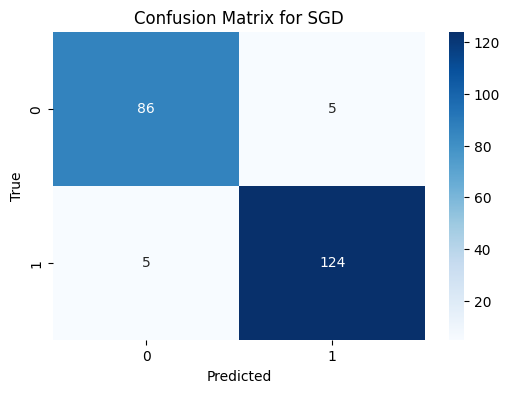

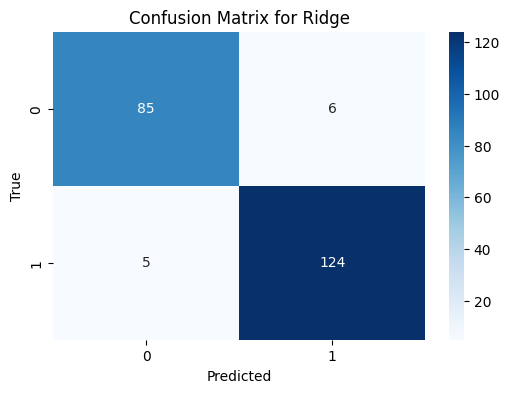

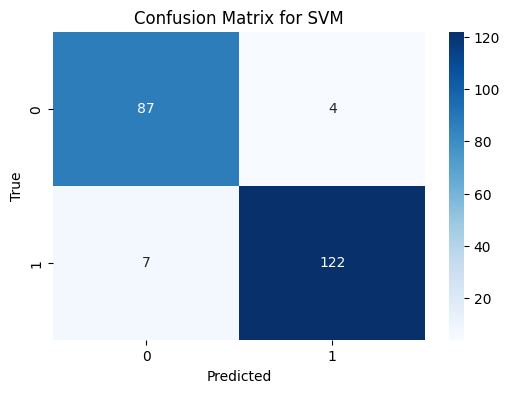

In [ ]:
# Plot confusion matrices for top 3 models
top_models = performance_df.head(3)['Algorithm']
for name in top_models:
    model = models[name]
    _, _, _, _, y_pred = train_classifier(model, X_train, Y_train, X_test, Y_test)
    cm = confusion_matrix(Y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

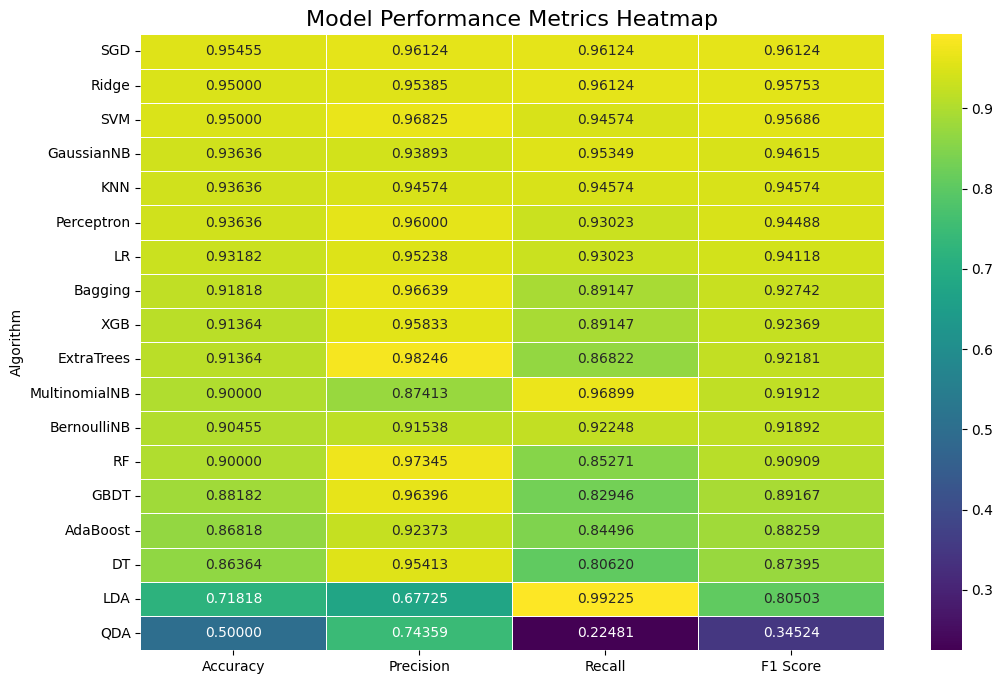

In [ ]:
#  Heatmap
plt.figure(figsize=(12, 8))
metrics = performance_df.set_index('Algorithm')[['Accuracy', 'Precision', 'Recall', 'F1 Score']]
sns.heatmap(metrics, annot=True, cmap='viridis', fmt=".5f", linewidths=0.5)
plt.title('Model Performance Metrics Heatmap', fontsize=16)

# Save the chart as an image
plt.savefig('Results/Train_farsi_sms/heatmap_model_performance_chart.png', dpi=600, bbox_inches='tight')

# Show the chart
plt.show()

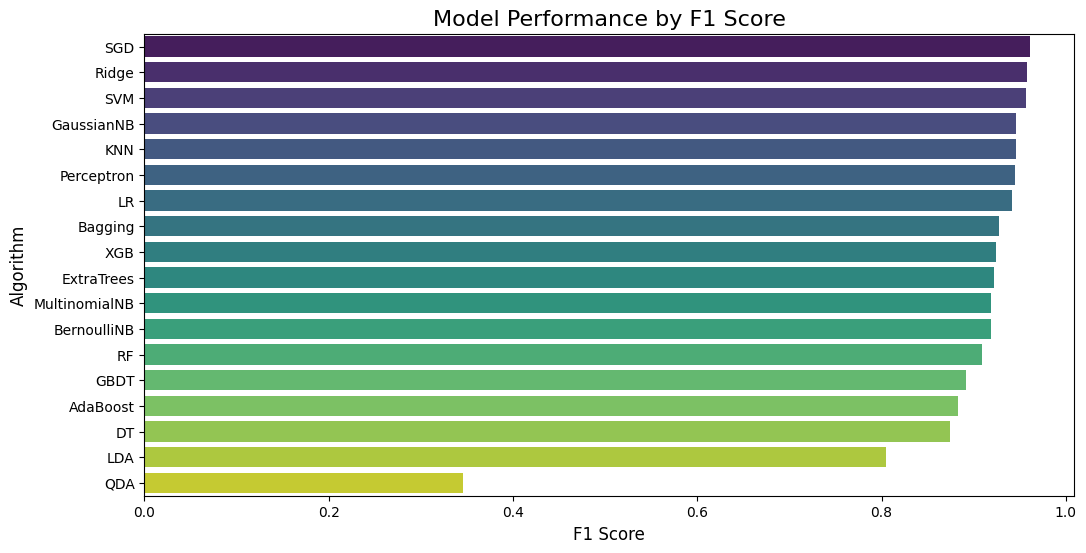

In [ ]:
# Bar plot for F1 Score
plt.figure(figsize=(12, 6))
sns.barplot(x='F1 Score', y='Algorithm', data=performance_df, palette='viridis')
plt.title('Model Performance by F1 Score', fontsize=16)
plt.xlabel('F1 Score', fontsize=12)
plt.ylabel('Algorithm', fontsize=12)

# Save the chart as an image
plt.savefig('Results/Train_farsi_sms/barplot_model_performance.png', dpi=600, bbox_inches='tight')

# Show the chart
plt.show()